# Behavioural Cloning CV
### Defining a reinforcement driving model
Here we seek to define a suitable loss model for reinforcement learning to take place.  Firstly, we need to use geometric image processing to compute surrounding boundaries and their relative distances to the edges of the car.  Once we have the car's position on the road we can then use this in a reinforcement learning scenario.

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import numpy as np
import cv2
%matplotlib inline

In [2]:
# plotting function for images
def plot(images, no_rows, no_cols, width = 10., height = 4., color='gray'):
    fig = plt.figure(1, (width, height))
    i = 0
    
    for image in images:
        sub = fig.add_subplot(no_rows, no_cols, i + 1)
        sub.imshow(image, color)
        sub.axis("off")
        i += 1

    plt.show()

In [3]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for [x1, y1, x2, y2] in line:        
            cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

In [4]:
import os
direct = 'images/'
files = os.listdir(direct)

In [5]:
# determine image dimensions
sample1 = mpimg.imread(os.path.join(direct, files[0]))
img_size = (sample1.shape[1], sample1.shape[0])

##### Sample image
A sample image from the training set, showing the surface, car hood and terrain.

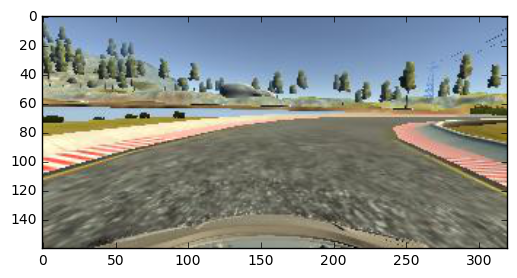

In [6]:
img_raw = mpimg.imread(os.path.join(direct, files[0]))
#vertex = rd.Vertex(img_raw.shape, min_width1=0.0, max_width1=1.0, min_width2=0., max_width2=1.,\
#                   min_height=0.45, max_height=0.8)
plt.imshow(img_raw)

### In search of road surfaces
Finding a decent surface extraction technique.

In [7]:
# import helper modules

import road as rd
import cvext as cvx

A selection of random samples from the center camera in the first track.

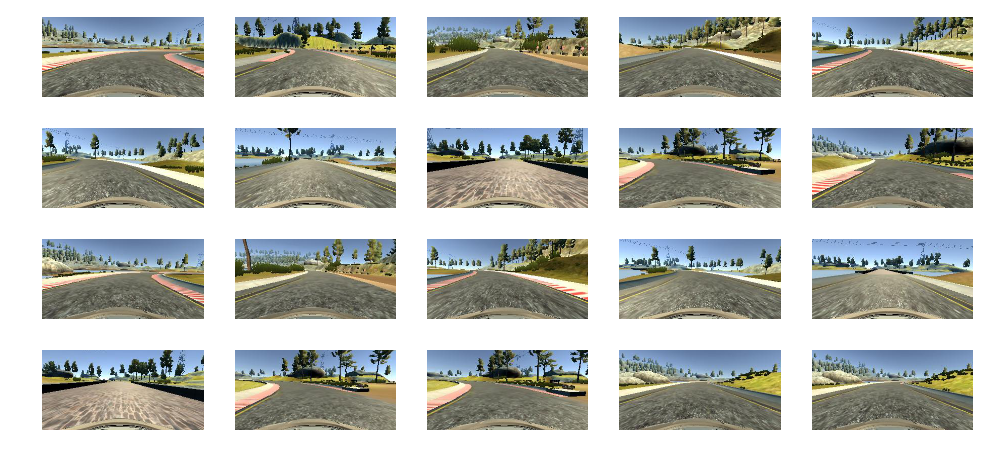

In [8]:
# load sample images and display

num_rows = 4
num_cols = 5
images = []

for file in files:
    image = mpimg.imread(os.path.join(direct, file))
    images.append(image)
plot(images, num_rows, num_cols, width=12., height=5.5)

Here's what the training data looks like in real-time.

In [9]:
HTML("""
<video width="480" height="320" controls>
  <source src="{0}">
</video>
""".format(os.path.join("videos", "Training.mp4")))

##### Colour Maps
Find a useful colour map space for finding road edges.

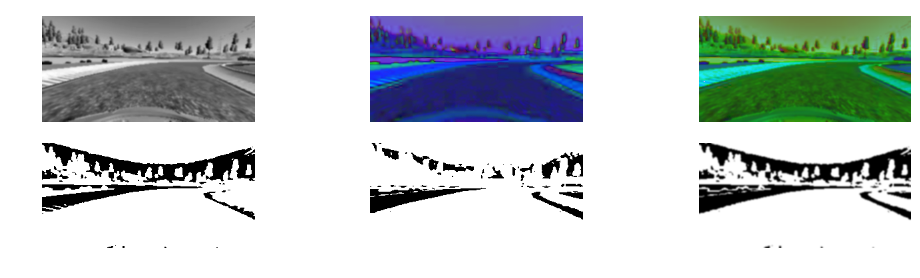

In [10]:
fill_mask = 255

img_blur = cvx.gaussian_blur(img_raw, 5)

imggray = cvx.to_GRAY(img_blur)
imghsv = cvx.to_HSV(img_blur)
imghsl = cvx.to_HLS(img_blur)
imgyuv = cvx.to_YUV(img_blur)
imghsl_t = imghsl[:,:,2]

img_mask1 = cvx.color_threshold(imgyuv[:,:,0], thresh=(0, 160), mask = fill_mask)
img_mask2 = cvx.color_threshold(imghsl[:,:,2], thresh=(0, 100), mask = fill_mask)
img_mask = cvx.binary_threshold(img_mask1, img_mask2, mask = fill_mask)
img_mask = cvx.gaussian_blur(img_mask, 5)

plot([imggray, imghsv, imghsl, img_mask1, img_mask2, img_mask], 2, 3, width=12., height=3.)

In [11]:
# mask road image
def mask_road_image(x):
    patch_region = np.array([[(x.shape[1]*0.2, x.shape[0]*0.8), (x.shape[1]*0.8, x.shape[0]*0.8),\
                             (x.shape[1]*0.2, x.shape[0]), (x.shape[1]*0.8, x.shape[0])]], dtype=np.int32)
    
    img_blur = cvx.gaussian_blur(x, 9)
    
    imghsl = cvx.to_HLS(img_blur)[:,:,2]
    imgyuv = cvx.to_YUV(img_blur)[:,:,0]
    
    imghsl_patch = cvx.region_of_interest(imghsl, patch_region)
    imgyuv_patch = cvx.region_of_interest(imgyuv, patch_region)
    
    imghsl = np.maximum(0, np.minimum(imghsl - np.max(imghsl_patch), fill_mask))
    imgyuv = np.maximum(0, np.minimum(imgyuv - np.max(imgyuv_patch), fill_mask))
    
    img_mask1 = cvx.color_threshold(imgyuv, thresh=(0,195), mask = fill_mask)
    img_mask2 = cvx.color_threshold(imghsl, thresh=(0,165), mask = fill_mask)
    
    img_mask = cvx.binary_threshold(img_mask1, img_mask2, mask = fill_mask)
    
    img_mask = cvx.gaussian_blur(img_mask, 1)
    
    return img_mask

mask_output = os.path.join("videos", "Training-masked.mp4")
clip_mask1 = VideoFileClip(os.path.join("videos", "Training.mp4"))
mask_clip = clip_mask1.fl_image(mask_road_image) #NOTE: this function expects color images!!
%time mask_clip.write_videofile(mask_output, audio=False)

[MoviePy] >>>> Building video videos\Training-masked.mp4
[MoviePy] Writing video videos\Training-masked.mp4


100%|███████████████████████████████████████████████████████████████████████████| 19264/19264 [01:12<00:00, 265.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos\Training-masked.mp4 

Wall time: 1min 12s


In [12]:
HTML("""
<video width="320" height="160" controls>
  <source src="{0}">
</video>
""".format(mask_output))

A few images with irregular road surfaces to check the validity of the road edge finding approach

In [13]:
hard_test = [images[0], images[2], images[5], images[7], images[11], images[14]]

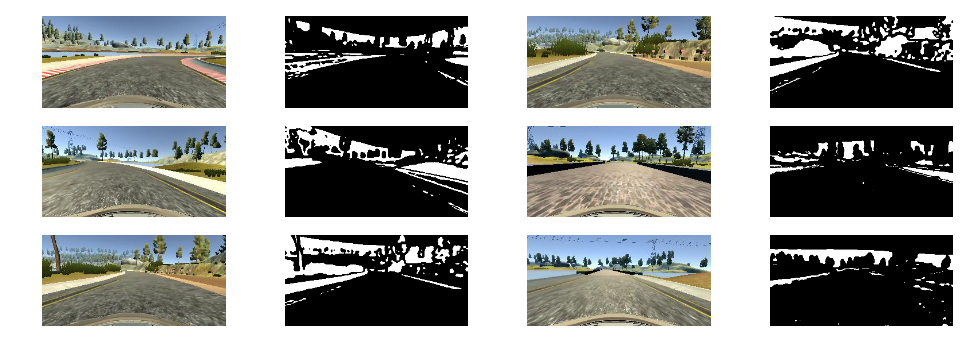

In [14]:
hard_test_new = []
for x in hard_test:
    hard_test_new.append(x)
    hard_test_new.append(mask_road_image(x))
plot(hard_test_new, 3, 4, width=12., height=4.)

In [15]:
from scipy import stats

### Pipeline for finding and extracting road edges
### with helper geometry functions

fill_mask = 255

width = img_size[0]
height = img_size[1]

vertices = np.array([[(0, height*0.42), (width, height*0.42), \
                      (width, height*0.85), (width/2.,height*0.4), \
                      (0, height*0.85)]], \
                     dtype=np.int32)

left_mask_vertices = np.array([[(0, 0),(width/2., 0), (width/2., height), (0, height)]], \
                     dtype=np.int32)
right_mask_vertices = np.array([[(width/2., 0),(width, 0), (width, height), (width/2., height)]], \
                     dtype=np.int32)

def y_intercept(x, m, c):
    return (m * x) + c

def x_intercept(y, m, c):
    return (y - c) / m

def line_intercept(line1, line2, epsilon = 1e-08):
    a1 = (line1[1] - line1[3]) / (line1[0] - line1[2])
    b1 = line1[1] - a1 * line1[0]

    a2 = (line2[1] - line2[3]) / (line2[0] - line2[2])
    b2 = line2[1] - a2 * line2[0]

    if (abs(a1 - a2) < epsilon):
        return None

    x = (b2 - b1) / (a1 - a2)
    y = a1 * x + b1
    return (x, y)

left_road_prev = None
right_road_prev = None

def find_road_edges(img, options, smooth=True, smooth_delta=0.6):
    global left_road_prev
    global right_road_prev
    
    img_input = mask_road_image(img)
    
    canny = cvx.canny(img_input, options.low_threshold, options.high_threshold)
    
    mask = np.zeros_like(canny)
    cv2.fillPoly(mask, vertices, options.fill_mask)
    masked_canny = cv2.bitwise_and(canny, mask)
    
    # left mask
    mask_left = np.zeros_like(canny)
    cv2.fillPoly(mask_left, left_mask_vertices, options.fill_mask)
    masked_canny_left = cv2.bitwise_and(masked_canny, mask_left)
    
    #left line
    left_points = cv2.findNonZero(masked_canny_left)
    
    [lm, lc, lr, lp, ls] = stats.linregress(left_points[:,0][:,0], left_points[:,0][:,1])
    [lx0, ly0, lx1, ly1] = [0, y_intercept(0, lm, lc), width/2., y_intercept(width/2, lm, lc)]
    
    # right mask
    mask_right = np.zeros_like(canny)
    cv2.fillPoly(mask_right, right_mask_vertices, options.fill_mask)
    masked_canny_right = cv2.bitwise_and(masked_canny, mask_right)
    
    #right line
    right_points = cv2.findNonZero(masked_canny_right)
    [rm, rc, rr, rp, rs] = stats.linregress(right_points[:,0][:,0], right_points[:,0][:,1])
    [rx0, ry0, rx1, ry1] = [width/2, y_intercept(width/2, rm, rc), width, y_intercept(width, rm, rc)]
    
    # get intersection
    ixy = line_intercept((lx0, ly0, lx1, ly1), (rx0, ry0, rx1, ry1))
    ixy = ((lx1+rx0+ixy[0]) / 3., (ly1+ry0+ixy[1]) / 3.)
    
    diff_y = (((ly1+ry0)/2.)-ixy[1])
    
    left = np.array([int(lx0), int(ly0+diff_y), int(ixy[0]), int(ixy[1])])
    right = np.array([int(ixy[0]), int(ixy[1]), int(rx1), int(ry1+diff_y)])
    
    if (left_road_prev is not None and smooth):
        left = np.average((left, left_road_prev), weights=(smooth_delta, 1.0-smooth_delta), axis=0)
        left_road_prev = np.copy(left)
    
    if (right_road_prev is not None and smooth):
        right = np.average((right, right_road_prev), weights=(smooth_delta, 1.0-smooth_delta), axis=0)
        right_r_prev = np.copy(right)
    
    left = left.astype(int)
    right = right.astype(int)
    
    return [left, right]

In [16]:
# get processing parameters

def get_options():
    options = rd.Options()
    
    options.kernel_size = 5
    # init params
    options.line_rotation = 0.42
    # hough lines
    options.rho = 3.0
    options.theta = np.pi/180*3.
    options.threshold = 18
    options.min_len_length = 140
    options.max_line_gap = 60
    # canny edge
    options.low_threshold = 120  # 120
    options.high_threshold = 220 # 220
    # line processor
    options.min_line_height = 0.6
    
    return options

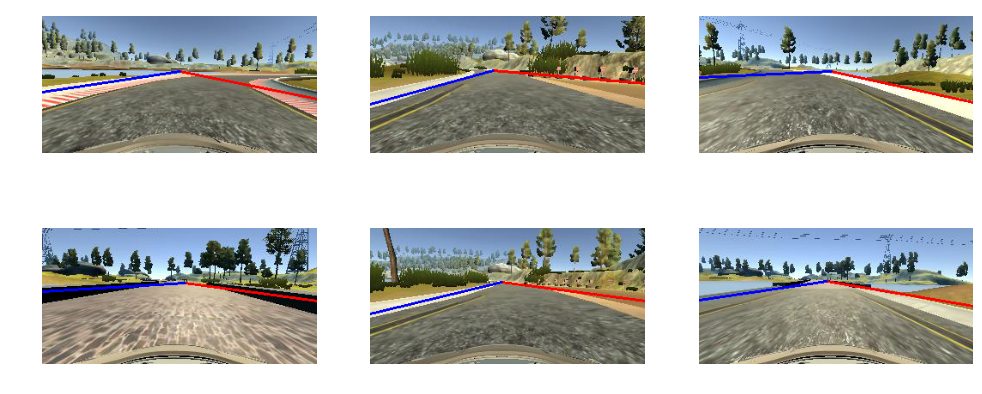

In [17]:
# sample some images and show detected road edges
surfaces = []

options = get_options()

for sample in hard_test:
    
    img = sample.copy()
    #ret, othresh = cv2.threshold(sample, 0, 1, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    [left, right] = find_road_edges(sample, options)
    
    img = cv2.line(img, (right[0], right[1]), (right[2], right[3]), (255,0,0), 2)
    img = cv2.line(img, (left[0], left[1]), (left[2], left[3]), (0,0,255), 2)
    
    surfaces.append(img)
    
plot(surfaces, 2, 3, width=12., height=5.)

## Reinforcement Learning
In order to define a reinforcement learning setting we need to define a simple markov decision process; a state, action and reward. The state is of course the environment which in this case is the road scene and the actions are the control surfaces of the car - i.e. throttle, brake and steering.

The reward function, responsible for computing the reward for the given state/action pair, needs to provide negative feedback when the car approaches the edges of the road and a positive reward when the car is in the middle of the road.  The reward should also take into account the speed of the car so that the car learns to move aswell...

The following defines the road edge detector which will be used to compute the reward.

### Define the road edge detectors
The following defines the edge detector for computing distances to road edges.

In [18]:
# Define the road edge distance method

# centroid is the common line origin
def find_edge_distances(image, options, x_coords=[0.05, 0.1, 0.2, 0.8, 0.9, 0.95], \
                       y_coords=[0.6, 0.5, 0.4, 0.4, 0.5, 0.6], centroid = None):
    [left, right] = find_road_edges(image, options)
    
    left_lines = []
    right_lines = []
    
    roadx = line_intercept(left, right)
    
    if (centroid == None):
        centroid = (image.shape[1]/2., image.shape[0])
    
    for x in range(len(x_coords)):
        # get positions
        x_pos = x_coords[x] * image.shape[1]
        y_pos = y_coords[x] * image.shape[0]
        
        # scan line
        line = [x_pos, y_pos, centroid[0], centroid[1]]
        
        ixy = None
        # check horizon (left or right)
        ixy_l = line_intercept(line, left)
        ixy_r = line_intercept(line, right)
        
        # get closest intercept
        if ((ixy_l != None) and (ixy_r != None)):
            if (ixy_l[1] >= ixy_r[1]):
                ixy = ixy_l
            else:
                ixy = ixy_r
        
        # if intersection, shorten line
        if (ixy != None):
            line = [ixy[0], ixy[1], centroid[0], centroid[1]]
        
        if (x_pos <= roadx[0]):
            left_lines.append(line)
        else:
            right_lines.append(line)
        
    left_lines = np.array(left_lines)
    right_lines = np.array(right_lines)
    
    return [left_lines, right_lines, (left, right)]

def add_lines(image, lines, color = [0,0,255]):
    line_img = np.zeros((image.shape), dtype=np.uint8)
    cvx.draw_lines(line_img, lines, color=color)
    img_res = cvx.weighted_img(line_img, image)
    return img_res

##### Reward Function
Here the function responsible for computing the loss/reward is defined.  This will allow the network to learn from its own driving behaviour.  Once the loss is available it can then be fed into the deep reinforcement learning model to allow learning to take place.

Reward function: 
$$ f_{reward}(s) = {{{(\frac{speed + 1}{speed^{max} + 1}) \times ((1-s_{loss} \times r^{max})-(s_{loss} \times r^{min}))} \over (r^{max} - r^{min})} \times (r^{max} - r^{min})-1} $$ 
$$ f_{loss}(dx) = \sqrt{\sum{(left_{dx}-right_{dx})^2}} $$

NOTE: Where $left_{dx}$ and $right_{dx}$ variables refer to the relative distance of the left and right road edges.  $r^{min}$ and $r^{max}$ refer to the reward function range, which in my case were -0.03 and 100, consecutively.

This reward function encodes the environment feedback (speed) relative to the neighbouring distances of the car.  This allows the agent to maximise speed and road space and penalises near misses with road edges.

### Computing the Reward value
The following shows the reward computation process

In [19]:
def reward(speed, left_dx, right_dx, max_speed = 100, r_min = -10, r_max = 100):
    sp = (speed + 1.) / (max_speed + 1.)
    
    dx = (np.sum(left_dx) - np.sum(right_dx)) / (np.sum(left_dx) + np.sum(right_dx))
    sse = np.sum(dx ** 2.)
    
    r =  ((1.0 - np.sqrt(sse)) * r_max) - (np.sqrt(sse) * r_min) 
    return ((sp * r) / (r_max - r_min)) * (r_max - r_min) - 1.0

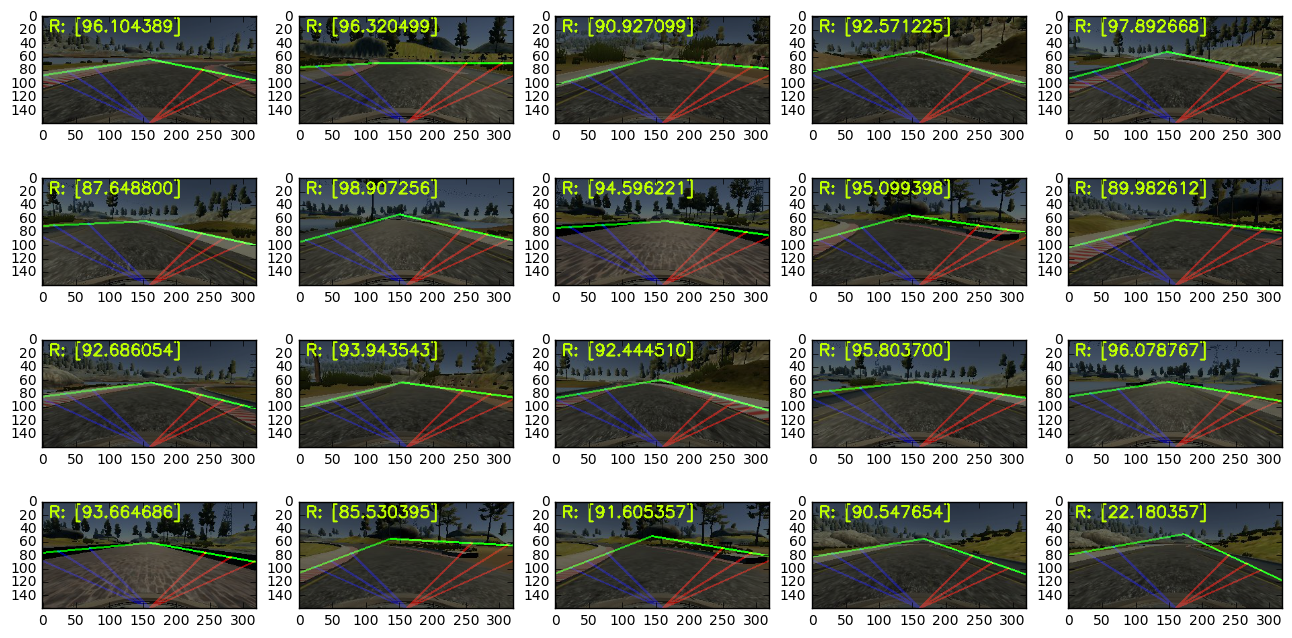

In [20]:
### process samples and display

# import cv helper library
# TODO: Migrate to road library when finished
import road as rd

left_prev = None
right_prev = None
rval = 0.
options = get_options()

def process_distances(left, right):
    # compute left distances
    left_dx = []
    for [x0, y0, x1, y1] in left:
        left_dx.append(cvx.distance(x0, y0, x1, y1))
    # compute right distances
    right_dx = []
    for [x0, y0, x1, y1] in right:
        right_dx.append(cvx.distance(x0, y0, x1, y1))

    left_dx = np.array(left_dx)
    right_dx = np.array(right_dx)
    
    return [left_dx, right_dx]

def process_image(img):
    
    global left_prev
    global right_prev
    global rval
    global options
    
    try:
        [left, right, road] = find_edge_distances(img, options)

        img_res = add_lines(img, left, [0,0,255])
        img_res = add_lines(img_res, right, [255,0,0])
        img_res = add_lines(img_res, [road[0]], [0,255,0])
        img_res = add_lines(img_res, [road[1]], [0,255,0])

        # compute distances
        [left_dx, right_dx] = process_distances(left, right)

        # compute reward
        rval = reward(100., left_dx, right_dx)

        left_prev = left
        right_prev = right

        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img_res, "R: [{:.6f}]".format(rval), (10,24), font, 0.8, (191, 255, 0), 2)
    except Exception as ex:
        img_res = img
    
    return img_res

fig = plt.figure(10, (16., 8.))
num_rows = 4
num_cols = 5
i = 0

for file in files:
    image = mpimg.imread(os.path.join(direct, file))
    
    # process image
    img_proc = process_image(image)
    sub = fig.add_subplot(num_rows, num_cols, i + 1)
    sub.imshow(img_proc)
    
    i += 1

plt.show()

#### Process Training Video
Preprocess each frame and compute the road edge, distances and reward.

In [21]:
# process sample video
sample_output = os.path.join("videos", "Training-processed.mp4")
clip1 = VideoFileClip(os.path.join("videos", "Training.mp4"))
train_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time train_clip.write_videofile(sample_output, audio=False)

[MoviePy] >>>> Building video videos\Training-processed.mp4
[MoviePy] Writing video videos\Training-processed.mp4


100%|███████████████████████████████████████████████████████████████████████████| 19264/19264 [02:27<00:00, 130.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos\Training-processed.mp4 

Wall time: 2min 27s


In [22]:
HTML("""
<video width="320" height="160" controls>
  <source src="{0}">
</video>
""".format(sample_output))